‐ distribution du poids des arêtes# PLDAC Modele de notebook pour proteine LARGE

## Initialisation

In [1]:
# !apt-get install -y pkg-config

In [2]:
# !pip3 install --upgrade pip

# !pip install -q igraph

# #octobre 2023
# !pip install -q pyspark==3.5.0

# !pip install -q pyarrow==4

# erreur?
# !pip install pycairo

affichage convivial des resultats d'une requete

In [30]:
pip install -q itables

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install --upgrade pyarrow

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from datetime import datetime
from datetime import date
from datetime import timedelta

# pour le chronomètre
import time

# for rmtree
import shutil


import igraph as ig

import networkx as nx

In [2]:

# from google.colab import data_table
# def display1(df, n=100):
#   return data_table.DataTable(pd.DataFrame(df.head(n), columns = df.columns), include_index=False, num_rows_per_page=10)



def display(df, n=20):
  pd.set_option('max_columns', None)
  pd.set_option('max_colwidth', None)
  return pd.DataFrame(df.head(n), columns = df.columns)
  # return df.limit(n).toPandas()

print("display redéfini")

display redéfini


In [3]:
# pour améliorer l'affichage des tableaux contenant le resultat d'une requete
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [4]:
!find /root -name "pyspark" |grep bin

/root/anaconda3/bin/pyspark
/root/anaconda3/pkgs/pyspark-3.1.2-pyhd3eb1b0_0/site-packages/pyspark/bin/pyspark
/root/anaconda3/lib/python3.9/site-packages/pyspark/bin/pyspark


In [9]:
!which java

/usr/bin/java


In [10]:
!java -version

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-post-Debian-1deb10u1)
OpenJDK 64-Bit Server VM (build 11.0.14+9-post-Debian-1deb10u1, mixed mode, sharing)


In [5]:
import os
os.environ["SPARK_HOME"] =  "/root/anaconda3/lib/python3.9/site-packages/pyspark" 
os.environ["JAVA_HOME"] ="/usr"

In [12]:
 # set java.io.tmpdir DOES NOT WORK
# os.environ["java.io.tmpdir"] ="/data/bd/tmp"

### Start spark 

In [6]:
import findspark 
print("findspark.init() initialise les variables d'environnement pour spark") 
findspark.init() 

from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# import pyspark functions
import pyspark.sql.functions as f

from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, ArrayType,StructType,StructField, BooleanType


findspark.init() initialise les variables d'environnement pour spark


In [7]:
def demarrer_spark():
    
  # 60 cores 
  NB_CORES = 60
  # NB_CORES = 64
  local = f"local[{NB_CORES}]"
  # local = "local[*]"
    

  # le parametre spark.local.dir indique le repertoire contenant les données temporaires ecrites sur disque lorsque le shufle ne tient pas en memoire
  
    
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "320G").\
  set("spark.driver.memory","320G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.driver.maxResultSize", "20G").\
  set("spark.local.dir", "/data/bd/spark/tmp").\
  set("spark.sql.execution.arrow.pyspark.enabled", "true")
    

# # to allow sharing in memory arow format between pandas and spark : speeds up the creation of a spark df from a pandas df
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    
  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (NB_CORES coeurs)
  shuffle_partitions = 3 * NB_CORES
  print("shuffle", shuffle_partitions)
  spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))    

  print("session démarrée, son id est ", sc.applicationId)
  return spark

spark = demarrer_spark()

# ignorer les warnings

24/04/03 17:24:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 17:24:25 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


shuffle 180
session démarrée, son id est  local-1712157866101


In [15]:
!ls /data/bd/dataset/proteine/80_80/G99

components.parquet		graph_nodeID_only_partitionned_200
graph				graph_partition_by_query_id
graph_deduplicated2		graph_partitionned
graph_nodeID_only		graph_removed
graph_nodeID_only_component	graph_with_components
graph_nodeID_only_partitionned	node_with_comp_and_annotation


In [8]:
G99 = "/data/bd/dataset/proteine/80_80/G99/"
nodes = spark.read.format("parquet").load(G99 + "graph_with_components") 

In [9]:
display(nodes)

query_id                                target_id  component_id  \
0   100000146:2                                2415031:4       1473714   
1    10000015:4  TARA_PON_109_MAG_00258_000000004457.1.1       5776874   
2   100000197:1                               21527879:2             0   
3   100001123:5                               99903473:0       1074173   
4   100002323:3                               34910384:0             0   
5   100002323:3                               42760527:2             0   
6   100003668:0                                1051841:5           529   
7   100003668:0                               42065852:0           529   
8   100003668:0                               48020206:1           529   
9   100004301:0                              104042249:0             0   
10  100004301:0                               71852508:0             0   
11  100004396:1                              106206892:2      10619426   
12   10000486:1                               40208488:3             0   
13  100005477:3                               46456023:2           529   
14  100005477:3                               46465067:0           529   
15  100005628:0                   EukProt-v2_ML04466a-PA         83786   
16  100005716:0                               60660288:0           529   
17  100006517:3                               64064543:3          4600   
18  100006517:3             EukProt-v2_GAXK01137596.1.p1          4600   
19  100007051:1                               81439233:3             0   

    query_length  target_length  match_length  percent_identity       e_value  \
0             53            269            57              93.0  1.200000e-20   
1            117            667           117              99.1  8.600000e-59   
2            152            137           137              99.3  7.800000e-68   
3             80            372            80             100.0  6.700000e-36   
4             70            328            70             100.0  3.900000e-30   
5             70            123            70             100.0  3.900000e-30   
6            102            304           102              99.0  2.900000e-55   
7            102            294           102              99.0  8.700000e-55   
8            102            111           103              98.1  9.600000e-54   
9            169            616           169              99.4  3.900000e-94   
10           169            627           169              99.4  3.600000e-94   
11            80            704            80             100.0  2.700000e-37   
12            77            120            77             100.0  1.100000e-28   
13            83            236            83             100.0  6.900000e-42   
14            83            225            83             100.0  6.900000e-42   
15            74            130            74             100.0  3.900000e-33   
16           111            256           111              99.1  9.800000e-60   
17           126           2784           126             100.0  1.500000e-64   
18           126           2127           126             100.0  6.700000e-65   
19           155             80            80             100.0  2.800000e-37   

    relative_sim  r  
0          1.000  1  
1          0.991  1  
2          0.993  1  
3          1.000  1  
4          1.000  1  
5          1.000  1  
6          0.990  1  
7          0.990  1  
8          0.991  1  
9          0.994  1  
10         0.994  1  
11         1.000  1  
12         1.000  1  
13         1.000  1  
14         1.000  1  
15         1.000  1  
16         0.991  1  
17         1.000  1  
18         1.000  1  
19         1.000  1

In [10]:
# TEST :
 
graph_edges = nodes.select("query_id","target_id","relative_sim")
edges_8 = nodes.filter((nodes["query_id"]=="101017938:0") | ( nodes["target_id"]=="101017938:0"))

display(edges_8)

query_id                          target_id  \
0                         17703062:0                        101017938:0   
1                        101017938:0   METdb_00312-1-DN8592-c0-g1-i1.p1   
2   METdb_00312-1-DN8592-c0-g1-i1.p1                        101017938:0   
3                        101017938:0  METdb_00308-1-Transcript-23943.p1   
4  METdb_00308-1-Transcript-23943.p1                        101017938:0   
5   METdb_00312-1-DN8592-c0-g1-i2.p1                        101017938:0   
6                        101017938:0   METdb_00312-1-DN8592-c0-g1-i2.p1   
7                        101017938:0                         17703062:0   

   component_id  query_length  target_length  match_length  percent_identity  \
0         10249           300            115           115             100.0   
1         10249           115            325           115              99.1   
2         10249           325            115           115              99.1   
3         10249           115            233           115             100.0   
4         10249           233            115           115             100.0   
5         10249           399            115           115              99.1   
6         10249           115            399           115              99.1   
7         10249           115            300           115             100.0   

        e_value  relative_sim  r  
0  5.200000e-57         1.000  1  
1  1.000000e-56         0.991  1  
2  2.100000e-56         0.991  1  
3  3.600000e-57         1.000  1  
4  4.000000e-57         1.000  1  
5  2.600000e-56         0.991  1  
6  1.000000e-56         0.991  1  
7  8.000000e-57         1.000  1

In [11]:
graph = spark.read.format("parquet").load(G99 + "node_with_comp_and_annotation") 
display(graph)

seq_id  component_id  pfamAcc
0   100004538:4         78310  PF00833
1   100007146:0             0  PF14560
2   100007146:0             0  PF11976
3   100007146:0             0  PF00240
4   100009521:3             0  PF00240
5   100009521:3             0  PF14560
6   100009521:3             0  PF11976
7   100011674:3             0  PF00125
8   100013434:4       5187617     None
9   100015378:4       5656844  PF01776
10  100018302:4       3599937     None
11   10001901:4       3986836     None
12  100022569:0       9997797     None
13  100024516:3             0  PF00125
14  100024516:3             0  PF00808
15  100025803:0        782652     None
16  100026381:3       1696849  PF03271
17  100030486:2             0  PF00240
18  100030486:2             0  PF11976
19  100031604:0       5662899     None

In [12]:
# nodes_2 = spark.read.format("parquet").load("/data/bd/dataset/proteine/80_80/subgraph_partition_by_group_coalesce") 
# display(nodes_2)

## Regroupement par id de composante :

In [13]:
#graph.groupby('component_id')['seq_id'].show()
#sorted(graph.groupBy('component_id').agg({'pfamAcc': 'count'}).collect())
from pyspark.sql.functions import *

group_per_component=graph.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))
group_per_component.show(20)



+------------+--------------------+------------------+
|component_id|              seq_id|           pfamAcc|
+------------+--------------------+------------------+
|         163|[122722351:2, 122...|                []|
|         303|[METdb_00180-1-DN...|                []|
|         549|[32161173:2, 4932...|                []|
|         650|[8877983:2, 99327...|         [PF02469]|
|         852|[65651042:4, 1376...|[PF10152, PF10152]|
|         870|[53913841:0, 8147...|                []|
|         906|[METdb_00412-1-Tr...|         [PF00574]|
|        1119|[EukProt-v2_HORVU...|                []|
|        1131|[EukProt-v2_HORVU...|                []|
|        1185|[EukProt-v2_TRINI...|                []|
|        1188|[142801656:5, TAR...|         [PF03006]|
|        1606|[108357923:1, MET...|                []|
|        1658|[METdb_00151-1-DN...|                []|
|        1697|[METdb_00180-1-DN...|         [PF07837]|
|        1779|[EukProt-v2_CAMPE...|                []|
|        1

In [26]:
#new
group_per_component_id=graph.groupBy(col("component_id")).agg(f.collect_set(col("seq_id")).alias("seq_ids_distincts"),collect_list(col("pfamAcc")).alias("annotations_pfamAcc"))
group_per_component_id.show(20)

+------------+--------------------+-------------------+
|component_id|   seq_ids_distincts|annotations_pfamAcc|
+------------+--------------------+-------------------+
|         163|[122722352:2, 122...|                 []|
|         303|[METdb_00183-1_DN...|                 []|
|         549|[49325225:2, 3216...|                 []|
|         650|[24665046:0, 4076...|          [PF02469]|
|         852|[139335784:3, 938...| [PF10152, PF10152]|
|         870|[9882677:2, 18029...|                 []|
|         906|[METdb_00409-1-Tr...|          [PF00574]|
|        1119|[EukProt-v2_HORVU...|                 []|
|        1131|[EukProt-v2_HORVU...|                 []|
|        1185|[EukProt-v2_TRINI...|                 []|
|        1188|[TARA_ARC_108_MAG...|          [PF03006]|
|        1606|[METdb_00148-1-DN...|                 []|
|        1658|[METdb_00145-1-DN...|                 []|
|        1697|[METdb_00150-1-DN...|          [PF07837]|
|        1779|[METdb_00170-1-Tr...|             

## Calcul des homogénéités :
*   Effectuer le calcul des homogénéités fonctionnelles pour chaque composante afin de déterminer si chaque composante ne possède aucune annotation, et le cas échéant, combien d'annotations différentes elle contient.
*   Formule : nb annoatations différentes / nb noeuds annotés

In [14]:

def calculate_size(text):
    return len(set(text))

calculate_size_udf = f.udf(lambda x: calculate_size(x), IntegerType())

# Apply the UDF

group_per_component_3 = group_per_component.withColumn("Indice_homogénéités", calculate_size_udf(f.col("pfamAcc")) / calculate_size_udf(f.col("seq_id"))) \
    .withColumn("Nb_annotation_diff", calculate_size_udf(f.col("pfamAcc"))) \
    .withColumn("Nb_noeuds", calculate_size_udf(f.col("seq_id")))\
    .withColumn("Nb_annotation_total",  size("pfamAcc") )

group_per_component_3.show(10)


+------------+--------------------+------------------+--------------------+------------------+---------+-------------------+
|component_id|              seq_id|           pfamAcc| Indice_homogénéités|Nb_annotation_diff|Nb_noeuds|Nb_annotation_total|
+------------+--------------------+------------------+--------------------+------------------+---------+-------------------+
|         163|[122722351:2, 122...|                []|                 0.0|                 0|        2|                  0|
|         303|[METdb_00180-1-DN...|                []|                 0.0|                 0|       90|                  0|
|         549|[32161173:2, 4932...|                []|                 0.0|                 0|        2|                  0|
|         650|[8877983:2, 99327...|         [PF02469]|0.002155172413793...|                 1|      464|                  1|
|         852|[65651042:4, 1376...|[PF10152, PF10152]|0.011235955056179775|                 1|       89|                  2|


Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [113]:
#new
def calculate_size(text):
    return len(set(text))

# def indice_homogeneite():
#     if Nb_annotation_total == 0 or Nb_annotation_total == 1  :
#         return Nb_annotation_total
#     else :
        
        
        
#         return 1-( nb_annotation_diff ) / nb_total noeuds
        

    
calculate_size_udf = f.udf(lambda x: calculate_size(x), IntegerType())

# Apply the UDF

group_per_component_id_infos = group_per_component_id.withColumn("Indice_homogénéités", calculate_size_udf(f.col("annotations_pfamAcc")) / calculate_size_udf(f.col("seq_ids_distincts"))) \
    .withColumn("Nb_annotation_diff", calculate_size_udf(f.col("annotations_pfamAcc"))) \
    .withColumn("Nb_noeuds", calculate_size_udf(f.col("seq_ids_distincts")))\
    .withColumn("Nb_annotation_total",  size("annotations_pfamAcc") )

group_per_component_id_infos.show(10)


+------------+--------------------+-------------------+--------------------+------------------+---------+-------------------+
|component_id|   seq_ids_distincts|annotations_pfamAcc| Indice_homogénéités|Nb_annotation_diff|Nb_noeuds|Nb_annotation_total|
+------------+--------------------+-------------------+--------------------+------------------+---------+-------------------+
|         163|[122722352:2, 122...|                 []|                 0.0|                 0|        2|                  0|
|         303|[METdb_00183-1_DN...|                 []|                 0.0|                 0|       90|                  0|
|         549|[49325225:2, 3216...|                 []|                 0.0|                 0|        2|                  0|
|         650|[24665046:0, 4076...|          [PF02469]|0.002155172413793...|                 1|      464|                  1|
|         852|[139335784:3, 938...| [PF10152, PF10152]|0.011235955056179775|                 1|       89|             

Traceback (most recent call last):                                              
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [141]:
def intersection_udf(list_column, target_list):
    return list(set(list_column) & set(target_list))

spark.udf.register("intersection_udf", intersection_udf, ArrayType(StringType()))

def annotations_distinctes_d_une_composante(id):
    node_of_component = graph.filter((graph['component_id']==id))
    node_of_component = node_of_component.select('seq_id','pfamAcc').groupBy(col("seq_id")).agg(f.collect_set(col("pfamAcc")).alias("annotations_pfamAcc"))
    node_of_component = node_of_component.withColumn("nombre_d_annotations",  size("annotations_pfamAcc") )
    
    # nombres_d_annotations_distincts_possibles = node_of_component.select('nombre_d_annotations').distinct().collect()
    
    nombres_d_annotations_distincts_possibles = node_of_component.select('nombre_d_annotations').distinct()

    # Triez les données en fonction de la colonne 'nombre_d_annotations'
    nombres_d_annotations_distincts_possibles = nombres_d_annotations_distincts_possibles.orderBy('nombre_d_annotations').collect()


    for nb in nombres_d_annotations_distincts_possibles:
        print(nb)
        new_df = None
        # Définir la condition pour les valeurs de nombre_d_annotations égales à 1
        if( (nb['nombre_d_annotations'] == 1 )or (nb['nombre_d_annotations'] == 0) ) : 
            condition_0 = col("nombre_d_annotations") == 0
            condition_1 = col("nombre_d_annotations") == 1

            # Appliquer la condition pour ajouter la nouvelle colonne
            new_df = node_of_component.withColumn("pfam", 
                                   when(condition_0, col("annotations_pfamAcc")[0])
                                  .otherwise( when(condition_1, col("annotations_pfamAcc")[0])))
        else :
            liste_des_colonnes = node_of_component.columns

            # Vérifiez si "pfam" est dans la liste des colonnes
            if "pfam" in liste_des_colonnes:

                liste_des_annotations_deja_presentes = [row.pfam for row in node_of_component.select("pfam").distinct().collect() if row.pfam is not None]
                
                new_df = (
                    node_of_component
                    .withColumn('a_list', f.array(*[f.lit(element) for element in liste_des_annotations_deja_presentes]))
                    .withColumn('intersection', f.array_intersect(f.col('annotations_pfamAcc'), 'a_list'))
                    .drop('a_list')
                )
                # Créer une colonne Spark à partir de la liste des annotations déjà présentes

                # intersection = f.array_intersect(col("annotations_pfamAcc"), f.array([liste_des_annotations_deja_presentes]))
                condition_inter_non_vide =  (col("nombre_d_annotations") == nb['nombre_d_annotations']) & (size(col('intersection'))>0)
                condition_inter_vide =   (col("nombre_d_annotations") == nb['nombre_d_annotations'])  & (size(col('intersection'))==0)
                # Appliquer la condition pour ajouter la nouvelle colonne
                new_df = new_df.withColumn("pfam", 
                           when(condition_inter_vide, col("annotations_pfamAcc")[0])
                           .when(condition_inter_non_vide, col('intersection')[0])
                           .otherwise(col("pfam"))) 
            else:
                 new_df = node_of_component.withColumn("pfam", col("annotations_pfamAcc")[0])
        new_df.show(10)
        if new_df != None :
            node_of_component = new_df

    return new_df

    
annotations_distinctes_d_une_composante('0').show(10)

Row(nombre_d_annotations=0)


+-----------+--------------------+--------------------+-------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|
+-----------+--------------------+--------------------+-------+
|100011547:3|[PF14560, PF00240...|                   4|   null|
|100053918:5|           [PF00022]|                   1|PF00022|
|100080892:3|           [PF03953]|                   1|PF03953|
|100098989:3|  [PF00240, PF11976]|                   2|   null|
|100129901:5|           [PF03953]|                   1|PF03953|
| 10013007:1|                  []|                   0|   null|
|100130276:4|[PF14560, PF00240...|                   4|   null|
|100151869:3|           [PF01599]|                   1|PF01599|
|100155195:0|           [PF00022]|                   1|PF00022|
|100166215:4|           [PF01434]|                   1|PF01434|
+-----------+--------------------+--------------------+-------+
only showing top 10 rows

Row(nombre_d_annotations=1)


+-----------+--------------------+--------------------+-------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|
+-----------+--------------------+--------------------+-------+
|100011547:3|[PF14560, PF00240...|                   4|   null|
|100053918:5|           [PF00022]|                   1|PF00022|
|100080892:3|           [PF03953]|                   1|PF03953|
|100098989:3|  [PF00240, PF11976]|                   2|   null|
|100129901:5|           [PF03953]|                   1|PF03953|
| 10013007:1|                  []|                   0|   null|
|100130276:4|[PF14560, PF00240...|                   4|   null|
|100151869:3|           [PF01599]|                   1|PF01599|
|100155195:0|           [PF00022]|                   1|PF00022|
|100166215:4|           [PF01434]|                   1|PF01434|
+-----------+--------------------+--------------------+-------+
only showing top 10 rows

Row(nombre_d_annotations=2)


+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|   null|  [PF00240, PF11976]|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|   null|[PF00240, PF11976...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|   null|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|   null|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

+-----------+--------------------+--------------------+-------+--------------------+
|     seq_id| annotations_pfamAcc|nombre_d_annotations|   pfam|        intersection|
+-----------+--------------------+--------------------+-------+--------------------+
|100011547:3|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100053918:5|           [PF00022]|                   1|PF00022|           [PF00022]|
|100080892:3|           [PF03953]|                   1|PF03953|           [PF03953]|
|100098989:3|  [PF00240, PF11976]|                   2|PF00240|  [PF00240, PF11976]|
|100129901:5|           [PF03953]|                   1|PF03953|           [PF03953]|
| 10013007:1|                  []|                   0|   null|                  []|
|100130276:4|[PF14560, PF00240...|                   4|PF14560|[PF14560, PF00240...|
|100151869:3|           [PF01599]|                   1|PF01599|           [PF01599]|
|100155195:0|           [PF00022]|                   1|PF00022|  

In [ ]:
def annotations_distinctes_d_une_composante_V2(id):
    # Filtrer les données pour le composant donné
    node_of_component = graph.filter(graph['component_id'] == id)
    
    # Agréger les annotations Pfam pour chaque seq_id
    node_of_component = node_of_component.groupBy('seq_id') \
                                         .agg(collect_set('pfamAcc').alias('annotations_pfamAcc')) \
                                         .withColumn('nombre_d_annotations', size('annotations_pfamAcc'))
    
    # Traitement des cas où nombre_d_annotations == 0 ou 1
    node_of_component = node_of_component.withColumn('pfam', 
                                                     when(col('nombre_d_annotations') == 0, col('annotations_pfamAcc')[0]) \
                                                    .when(col('nombre_d_annotations') == 1, col('annotations_pfamAcc')[0]))
    
    # Traitement des autres cas
    for nb_row in node_of_component.select('nombre_d_annotations').distinct().orderBy('nombre_d_annotations').collect():
        nb = nb_row['nombre_d_annotations']
        if nb not in [0, 1]:
            liste_des_annotations_deja_presentes = node_of_component.select(explode('annotations_pfamAcc').alias('pfam')).distinct()

            # Convertir la liste des annotations Pfam déjà présentes en une liste Python
            liste_pfams = [row['pfam'] for row in liste_des_annotations_deja_presentes.collect()]

            # Créer une colonne 'new' contenant la liste des annotations Pfam déjà présentes
            node_of_component = node_of_component.withColumn('new', array(*[col('pfam') for pfam in liste_pfams]))

            # Calculer l'intersection entre 'new' et 'annotations_pfamAcc'
            node_of_component = node_of_component.withColumn('intersection', array_intersect(col('new'), col('annotations_pfamAcc')))

                    # Déterminer quelle annotation utiliser en fonction de l'intersection
            node_of_component = node_of_component.withColumn('pfam', 
                                                             when((col("nombre_d_annotations") == nb) & (size(col('intersection')) > 0), col('intersection')[0]) \
                                                            .when((col("nombre_d_annotations") == nb) & (size(col('intersection')) == 0), col('annotations_pfamAcc')[0])
                                                             .otherwise(col('pfam')))
    
        node_of_component.show(10)
    return node_of_component

annotations_distinctes_d_une_composante_V2('0')


## Fréquence des Indice d'homogénéités :

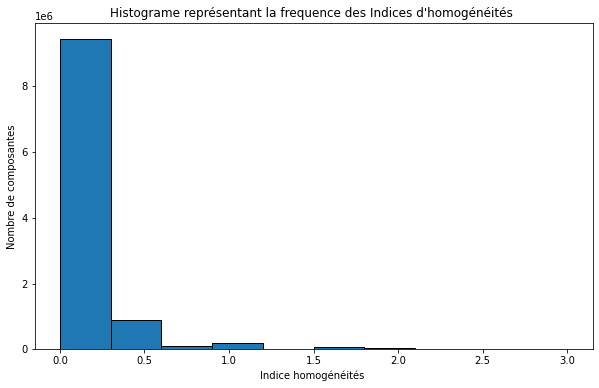

In [15]:

import matplotlib.pyplot as plt
# Filtrer les valeurs où "Indice_homogénéités" est inférieur ou égal à 5
filtered_df = group_per_component_3.filter(group_per_component_3["Indice_homogénéités"] <= 3)

# Collecter les résultats
count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
#count_values = group_per_component_3.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(count_values, bins=10, edgecolor='black')
plt.xlabel('Indice homogénéités ')
plt.ylabel('Nombre de composantes')
plt.title('Histograme représentant la frequence des Indices d\'homogénéités ')
plt.show()


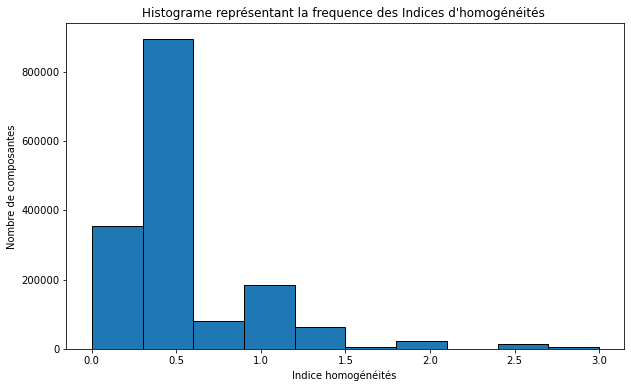

In [16]:
import matplotlib.pyplot as plt
# Filtrer les valeurs où "Indice_homogénéités" est inférieur ou égal à 5
filtered_df = group_per_component_3.filter((group_per_component_3["Indice_homogénéités"] <= 3) & (group_per_component_3["Indice_homogénéités"] >0 ) )

# Collecter les résultats
count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
#count_values = group_per_component_3.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(count_values, bins=10, edgecolor='black')
plt.xlabel('Indice homogénéités ')
plt.ylabel('Nombre de composantes')
plt.title('Histograme représentant la frequence des Indices d\'homogénéités ')
plt.show()


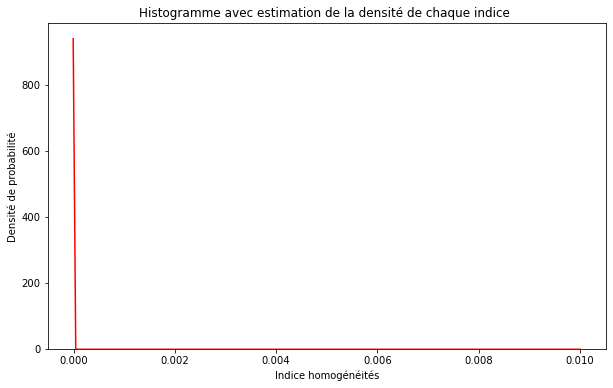

In [248]:


# Collecte des valeurs de l'indice d'homogénéité
filtered_df = group_per_component_3.filter(group_per_component_3["Indice_homogénéités"] <= 0.01)

count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
# Définition des labels et du titre
plt.figure(figsize=(10,6))
# Tracer l'estimation de la densité du noyau (KDE)
sns.kdeplot(count_values, color='r')



plt.xlabel('Indice homogénéités')
plt.ylabel('Densité de probabilité')
plt.title('Histogramme avec estimation de la densité de chaque indice ')

# Affichage du graphique
plt.show()

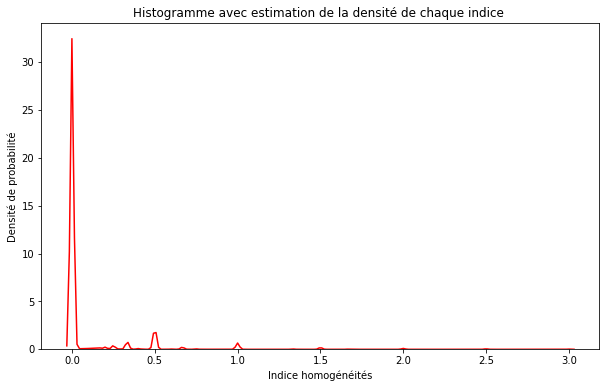

In [253]:


# Collecte des valeurs de l'indice d'homogénéité
filtered_df = group_per_component_3.filter(group_per_component_3["Indice_homogénéités"] <= 3)

count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
# Définition des labels et du titre
plt.figure(figsize=(10,6))
# Tracer l'estimation de la densité du noyau (KDE)
sns.kdeplot(count_values, color='r')



plt.xlabel('Indice homogénéités')
plt.ylabel('Densité de probabilité')
plt.title('Histogramme avec estimation de la densité de chaque indice ')

# Affichage du graphique
plt.show()

## Récuperation du nombre de seq annotées :

In [24]:
group_seq_annotees = graph.filter(graph["pfamAcc"]!= 'None')

group_seq_annotees_per_component=group_seq_annotees.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))

group_seq_annotees_per_component_count= group_seq_annotees_per_component.withColumn("Nb_noeuds_annotes", calculate_size_udf(f.col("seq_id"))) \
    .withColumn("Nb_noeuds_annotes_tot", size(f.col("seq_id"))) \
    .withColumn("Nb_annotation_diff",  calculate_size_udf("pfamAcc") )\
    .withColumn("Nb_annotation_total",  size("pfamAcc") )

group_seq_annotees_per_component_count.show(10)


+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|component_id|              seq_id|             pfamAcc|Nb_noeuds_annotes|Nb_noeuds_annotes_tot|Nb_annotation_diff|Nb_annotation_total|
+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|         650|        [48387767:4]|           [PF02469]|                1|                    1|                 1|                  1|
|         852|[154749929:5, 136...|  [PF10152, PF10152]|                2|                    2|                 1|                  2|
|         906|       [134435551:3]|           [PF00574]|                1|                    1|                 1|                  1|
|        1188|       [142801656:5]|           [PF03006]|                1|                    1|                 1|                  1|
|        1697|       [108186008:4]|           [P

In [25]:
group_seq_annotees_per_component_count.filter(group_seq_annotees_per_component_count["component_id"]==10249).show()

+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|component_id|              seq_id|             pfamAcc|Nb_noeuds_annotes|Nb_noeuds_annotes_tot|Nb_annotation_diff|Nb_annotation_total|
+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|       10249|[99263308:0, 9926...|[PF13561, PF00106...|                5|                   10|                 2|                 10|
+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+



In [26]:
jointure_df = group_seq_annotees_per_component_count.select("component_id","Nb_noeuds_annotes").join(group_per_component_3.select("component_id","Nb_noeuds"), "component_id", "inner")
jointure_df.show(20)


+------------+-----------------+---------+
|component_id|Nb_noeuds_annotes|Nb_noeuds|
+------------+-----------------+---------+
|         650|                1|      464|
|         852|                2|       89|
|         906|                1|       15|
|        1188|                1|        3|
|        1697|                1|       46|
|        2326|                1|        5|
|        4959|              196|      196|
|        5794|                2|       37|
|        7117|                4|        5|
|        7348|                2|        4|
|        8040|                5|       94|
|        8637|               25|       67|
|        8888|               17|       23|
|        9974|                5|       69|
|       10249|                5|        8|
|       10289|               27|       60|
|       10642|                2|        8|
|       11405|               50|       78|
|       11712|                1|       17|
|       12871|                2|        2|
+----------

In [131]:
jointure_df.orderBy(f.col("Nb_noeuds_annotes").desc()).show(20)

+------------+-----------------+---------+
|component_id|Nb_noeuds_annotes|Nb_noeuds|
+------------+-----------------+---------+
|           0|          1131494|  1351764|
|           9|            41609|    45517|
|          17|            33650|    42311|
|         751|            12185|    13568|
|          54|            11823|    13567|
|         425|            11006|    11699|
|           2|             8419|     9171|
|         383|             7916|     8760|
|         220|             7551|    10602|
|         119|             6774|     7654|
|         327|             6674|     7350|
|         752|             6646|     7732|
|        9282|             6340|     7669|
|        2757|             5847|     6148|
|          38|             5539|     6019|
|          11|             5504|     6059|
|         136|             5355|     5891|
|          48|             5319|     6499|
|         298|             5314|     5705|
|        6698|             5159|     5502|
+----------

In [108]:
jointure_df.count()# nombre d ecomposantes comporant des noedus annotés

1639295

In [109]:
group_per_component_3.count() #Nombre de composantes total

10734801

In [33]:
unique_sizes, counts = jointure_df.select("Nb_noeuds").rdd.map(lambda x: x[0]).collect(),jointure_df.select("Nb_noeuds_annotes").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes
plt.figure(figsize=(10,6))

plt.plot(unique_sizes, counts, marker='.', linestyle='none')

plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('taille composante')
plt.ylabel('nombre de noeuds annotés')
plt.title('Distribution du nombre de noeuds annotés en fonction de la taille des composantes')

plt.show()

#
# There is insufficient memory for the Java Runtime Environment to continue.
# Native memory allocation (mmap) failed to map 101669928960 bytes for committing reserved memory.
# An error report file with more information is saved as:
# /root/PLDAC/hs_err_pid20057.log


OpenJDK 64-Bit Server VM warning: INFO: os::commit_memory(0x00007ed3a8000000, 101669928960, 0) failed; error='Not enough space' (errno=12)
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58524)
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33775)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/root/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkErro

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:33775)

In [127]:
nb_annot_possible_per_taille = jointure_df.groupBy("Nb_noeuds").agg(collect_list(col("Nb_noeuds_annotes")).alias("Nb_noeuds_annotes"))
nb_annot_possible_per_taille.show(20)

+---------+--------------------+
|Nb_noeuds|   Nb_noeuds_annotes|
+---------+--------------------+
|      748|               [641]|
|      411|  [338, 9, 163, 390]|
|     4613|              [3835]|
|      473|               [394]|
|      779|          [442, 237]|
|      783|          [598, 608]|
|      471|          [292, 277]|
|      612|               [465]|
|      537|          [393, 475]|
|      960|                [42]|
|       54|[3, 2, 52, 53, 1,...|
|      105|[5, 105, 6, 35, 2...|
|      165|[114, 119, 112, 6...|
|       99|[2, 1, 1, 28, 54,...|
|      173|[10, 173, 82, 5, ...|
|      301|[289, 101, 169, 2...|
|      243|[202, 9, 218, 215...|
|      743|               [647]|
|       58|[13, 2, 30, 37, 3...|
|       77|[46, 64, 42, 65, ...|
+---------+--------------------+
only showing top 20 rows



In [120]:
noeud_annote_per_taille = jointure_df.groupBy("Nb_noeuds").agg(avg("Nb_noeuds_annotes").alias("avg_noeuds_annotes"))
noeud_annote_per_taille.show()


+---------+------------------+
|Nb_noeuds|avg_noeuds_annotes|
+---------+------------------+
|      748|             641.0|
|      411|             225.0|
|     4613|            3835.0|
|      473|             394.0|
|      779|             339.5|
|      783|             603.0|
|      471|             284.5|
|      612|             465.0|
|      537|             434.0|
|      960|              42.0|
|       54| 23.24590163934426|
|      105|           54.8125|
|      165| 85.52173913043478|
|       99|              45.2|
|      173| 94.57142857142857|
|      301|             189.0|
|      243|128.21428571428572|
|      743|             647.0|
|       58|25.972868217054263|
|       77| 35.73154362416108|
+---------+------------------+
only showing top 20 rows



## Affichage d'une composante donnée : 

In [254]:
 
graph_edges = nodes.select("query_id","target_id","relative_sim")
display(graph_edges)


query_id                                target_id  relative_sim
0   100000146:2                                2415031:4         1.000
1    10000015:4  TARA_PON_109_MAG_00258_000000004457.1.1         0.991
2   100000197:1                               21527879:2         0.993
3   100001123:5                               99903473:0         1.000
4   100002323:3                               34910384:0         1.000
5   100002323:3                               42760527:2         1.000
6   100003668:0                                1051841:5         0.990
7   100003668:0                               42065852:0         0.990
8   100003668:0                               48020206:1         0.991
9   100004301:0                              104042249:0         0.994
10  100004301:0                               71852508:0         0.994
11  100004396:1                              106206892:2         1.000
12   10000486:1                               40208488:3         1.000
13  100005477:3                               46456023:2         1.000
14  100005477:3                               46465067:0         1.000
15  100005628:0                   EukProt-v2_ML04466a-PA         1.000
16  100005716:0                               60660288:0         0.991
17  100006517:3                               64064543:3         1.000
18  100006517:3             EukProt-v2_GAXK01137596.1.p1         1.000
19  100007051:1                               81439233:3         1.000

In [255]:
# Recuprer les arrete d'une composante : 10249
vertices = group_per_component_3.filter( group_per_component_3["component_id"]==10249)

vertices.show() 

+------------+--------------------+--------------------+-------------------+------------------+---------+-------------------+
|component_id|              seq_id|             pfamAcc|Indice_homogénéités|Nb_annotation_diff|Nb_noeuds|Nb_annotation_total|
+------------+--------------------+--------------------+-------------------+------------------+---------+-------------------+
|       10249|[METdb_00312-1-DN...|[PF13561, PF00106...|               0.25|                 2|        8|                 10|
+------------+--------------------+--------------------+-------------------+------------------+---------+-------------------+



In [256]:
#list_nodes = edges.select("seq_Id").rdd.map(lambda x: x[0]).collect()
#graph_edges.filter(graph_edges["query_id"]in edges & graph_edges["query_id"] in edges).show(20)
# Convertir les valeurs de seq_id en une liste Python
seq_ids_list = [row.seq_id for row in vertices.select("seq_id").distinct().collect()][0]
print(seq_ids_list)
# Filtrer les arêtes du graphe en fonction de ces valeurs
edges = graph_edges.filter((graph_edges["query_id"].isin(seq_ids_list)) &( graph_edges["target_id"].isin(seq_ids_list)))
edges.show()
#filtered_edges = graph_edges.filter(graph_edges["query_id"].isin(edges.select("seq_id")) & graph_edges["target_id"].isin(edges.select("seq_id"))).show(10)


['METdb_00312-1-DN8592-c0-g1-i2.p1', '99263308:0', '99263308:0', '101017938:0', '101017938:0', '17703062:0', '17703062:0', 'METdb_00312-1-DN8592-c0-g1-i1.p1', 'METdb_00308-1-Transcript-23943.p1', '3935503:4', '3935503:4', '48424537:2', '48424537:2']


+--------------------+--------------------+------------+
|            query_id|           target_id|relative_sim|
+--------------------+--------------------+------------+
|          48424537:2|METdb_00308-1-Tra...|         1.0|
|METdb_00312-1-DN8...|METdb_00308-1-Tra...|       0.991|
|METdb_00308-1-Tra...|          99263308:0|         1.0|
|METdb_00312-1-DN8...|METdb_00312-1-DN8...|         1.0|
|          48424537:2|METdb_00312-1-DN8...|         1.0|
|          17703062:0|         101017938:0|         1.0|
|         101017938:0|METdb_00312-1-DN8...|       0.991|
|METdb_00312-1-DN8...|         101017938:0|       0.991|
|METdb_00308-1-Tra...|METdb_00312-1-DN8...|       0.991|
|          48424537:2|          17703062:0|         1.0|
|         101017938:0|METdb_00308-1-Tra...|         1.0|
|          17703062:0|          99263308:0|         1.0|
|METdb_00308-1-Tra...|         101017938:0|         1.0|
|          48424537:2|METdb_00312-1-DN8...|         1.0|
|          99263308:0|METdb_003

['101017938:0' '17703062:0' '3935503:4' '48424537:2' '99263308:0']
[Row(seq_id='3935503:4', pfamAcc='PF00106'), Row(seq_id='48424537:2', pfamAcc='PF00106'), Row(seq_id='48424537:2', pfamAcc='PF13561'), Row(seq_id='101017938:0', pfamAcc='PF13561'), Row(seq_id='99263308:0', pfamAcc='PF13561'), Row(seq_id='101017938:0', pfamAcc='PF00106'), Row(seq_id='17703062:0', pfamAcc='PF00106'), Row(seq_id='3935503:4', pfamAcc='PF13561'), Row(seq_id='99263308:0', pfamAcc='PF00106'), Row(seq_id='17703062:0', pfamAcc='PF13561')]


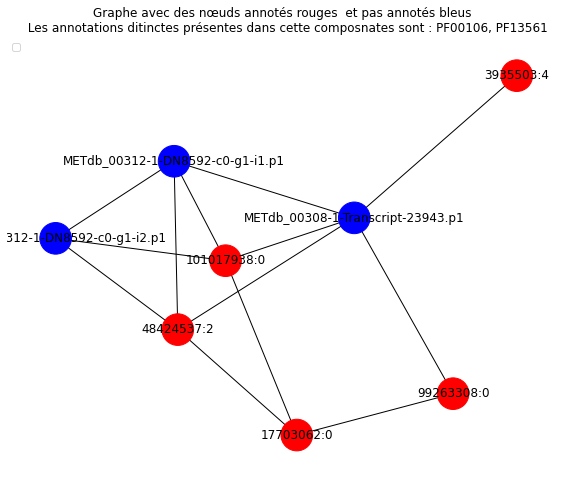

In [292]:

# Créer un graphe NetworkX
G = nx.Graph()

# Ajouter les arêtes au graphe
for edge in edges_g:
    source, target = edge
    G.add_edge(source, target)


# Liste de nœuds avec couleurs spécifiques pour chaque groupe
les_annotations = group_seq_annotees_per_component_count.filter(group_seq_annotees_per_component_count["component_id"]==10249).select("pfamAcc").distinct().collect()
les_annotations = np.unique(les_annotations[0].pfamAcc)


nodes_annote = group_seq_annotees_per_component_count.filter(group_seq_annotees_per_component_count["component_id"]==10249)
nodes_annote = np.unique([row.seq_id for row in nodes_annote.select("seq_id").distinct().collect()][0])
print(nodes_annote)

les_annotations_bis = graph.filter(graph["seq_id"].isin( list(nodes_annote))).select("seq_id","pfamAcc").distinct().collect()
print(les_annotations_bis)

result = list(set(seq_ids_list) - set(nodes_annote))
# Ajouter des nœuds rouges au graphe
for node in nodes_annote:
    G.add_node(node, color='red')

# Ajouter des nœuds bleus au graphe
for node in result:
    G.add_node(node, color='blue')

# Dessiner le graphe avec les couleurs spécifiées
colors = [G.nodes[node]['color'] for node in G.nodes]
plt.figure(figsize=(10, 8))
plt.legend(labels=[f"{label}" for label in les_annotations], loc="upper left")

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, edge_color='black', linewidths=1, font_size=12)
plt.title("Graphe avec des nœuds annotés rouges  et pas annotés bleus  "+"\n Les annotations ditinctes présentes dans cette composnates sont : "+", ".join(les_annotations))
plt.show()

In [50]:
group_indice_homog = group_per_component_3.groupBy(col("Indice_homogénéités")).count()
group_indice_homog.show(10)

+--------------------+-----+
| Indice_homogénéités|count|
+--------------------+-----+
|  0.7142857142857143|  948|
|0.006557377049180328|    2|
|0.030927835051546393|   10|
|  0.3103448275862069|    3|
|               0.024|    9|
|0.010794896957801767|    1|
|0.001996007984031936|    2|
|0.018957345971563982|    2|
|   0.391304347826087|    5|
| 0.05063291139240506|   10|
+--------------------+-----+
only showing top 10 rows



## Regroupement par nombre d'annotations différentes :

In [51]:
group_bn_annot_diff = group_per_component_3.groupBy(col("Nb_annotation_diff")).count()
group_bn_annot_diff.show(10)

+------------------+-----+
|Nb_annotation_diff|count|
+------------------+-----+
|                54|    2|
|                58|    2|
|                21|   10|
|                23|   10|
|                 9| 1275|
|                92|    1|
|                25|    6|
|                42|    2|
|                15|   54|
|                 7| 5809|
+------------------+-----+
only showing top 10 rows



## Regroupement par nombre d'annotations total: :

In [52]:
group_bn_annot_total = group_per_component_3.groupBy(col("Nb_annotation_total")).count()
group_bn_annot_total.show(10)

+-------------------+-----+
|Nb_annotation_total|count|
+-------------------+-----+
|                748|    1|
|                537|    4|
|                471|    2|
|                603|    1|
|                307|    3|
|                612|    2|
|                660|    1|
|                473|    2|
|                783|    1|
|                960|    1|
+-------------------+-----+
only showing top 10 rows



In [53]:
filtered_df_1 = group_bn_annot_diff.filter(group_bn_annot_diff["Nb_annotation_diff"] == 1)
filtered_df_0 = group_bn_annot_total.filter(group_bn_annot_total["Nb_annotation_total"] == 0)

filtered_df_1 = filtered_df_1.first()
filtered_df_1 = filtered_df_1["count"]

filtered_df_0 = filtered_df_0.first()
filtered_df_0 = filtered_df_0["count"]

print("Le nombre de composantes ayant qu'une seule annotation est de :" , filtered_df_1)
print("Le nombre de composantes n'ayant aucune annotation est de :" , filtered_df_0)


Le nombre de composantes ayant qu'une seule annotation est de : 1087851
Le nombre de composantes n'ayant aucune annotation est de : 9095506


## Fréquence du nombre d'annotations différentes :

[54, 58, 21, 23, 9, 92, 25, 42, 15, 7, 16, 27, 49, 14, 6, 19, 32, 56, 30, 31, 52, 17, 18, 40, 28, 24, 62, 44, 55, 11, 50, 22, 34, 10, 38, 57, 29, 8, 37, 48, 5, 20, 47, 41, 46, 39, 13, 26, 4, 59, 1, 33, 12, 0, 3, 2, 2115, 43]
[2, 2, 10, 10, 1275, 1, 6, 2, 54, 5809, 30, 4, 1, 88, 13837, 12, 4, 1, 2, 3, 3, 20, 23, 2, 3, 4, 1, 1, 1, 350, 1, 9, 3, 608, 1, 1, 5, 2844, 1, 1, 32173, 15, 2, 3, 2, 2, 133, 5, 51928, 1, 1087851, 3, 220, 9095506, 114577, 327343, 1, 1]


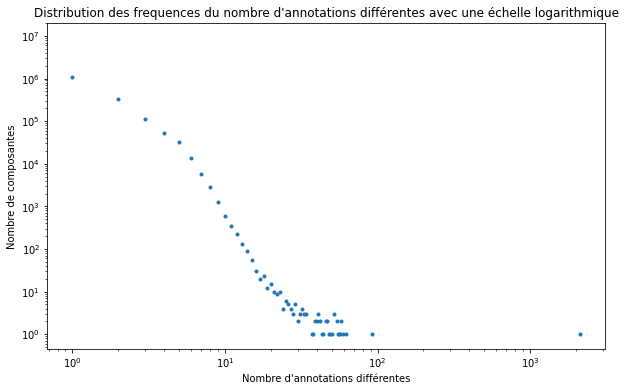

In [295]:
import numpy as np

unique_sizes, counts = group_bn_annot_diff.select("Nb_annotation_diff").rdd.map(lambda x: x[0]).collect(),group_bn_annot_diff.select("count").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes
plt.figure(figsize=(10,6))

plt.plot(unique_sizes, counts, marker='.', linestyle='none')
plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre d\'annotations différentes')
plt.ylabel('Nombre de composantes')
plt.title('Distribution des frequences du nombre d\'annotations différentes avec une échelle logarithmique')

plt.show()

In [296]:
print("Size max  : ",np.max(unique_sizes), "avec frequece ",np.min(counts))
print("Frequence max des composantes de tailles petite : ",np.min(unique_sizes)," est de  : ",np.max(counts))

Size max  :  2115 avec frequece  1
Frequence max des composantes de tailles petite :  0  est de  :  9095506


## Fréquence du nombre d'annotations totales :

[748, 537, 471, 603, 307, 612, 660, 473, 783, 960, 411, 105, 54, 165, 173, 99, 1025, 243, 301, 2014, 743, 1038, 58, 77, 516, 2167, 1664, 21, 871, 66, 460, 206, 241, 590, 3176, 930, 83, 383, 1902, 23, 481, 212, 535, 1022, 1730, 866, 1651, 45, 88, 632, 1116, 6674, 561, 926, 345, 1232, 877, 996, 663, 864, 244, 673, 238, 633, 2101, 9, 285, 863, 474, 375, 720, 6492, 3384, 976, 92, 971, 604, 1278, 1013, 240, 2783, 621, 998, 25, 232, 2852, 782, 42, 141, 117, 175, 1222, 337, 899, 1426, 1388, 201, 1197, 334, 1043, 381, 436, 1201, 656, 765, 35, 735, 1412, 479, 1501, 378, 692, 140, 521, 1300, 5487, 15, 152, 250, 617, 310, 478, 377, 731, 315, 239, 2092, 291, 955, 292, 304, 1037, 463, 1590, 606, 623, 651, 8803, 741, 361, 253, 684, 512, 1202, 1270, 100, 489, 1551, 580, 161, 1093, 458, 452, 1283, 770, 1223, 687, 61, 352, 127, 316, 523, 2997, 492, 531, 274, 616, 7, 162, 547, 689, 637, 107, 198, 218, 2231651, 1108, 16, 84, 1520, 551, 1468, 975, 288, 167, 945, 394, 728, 342, 2407, 289, 630, 745, 93, 101

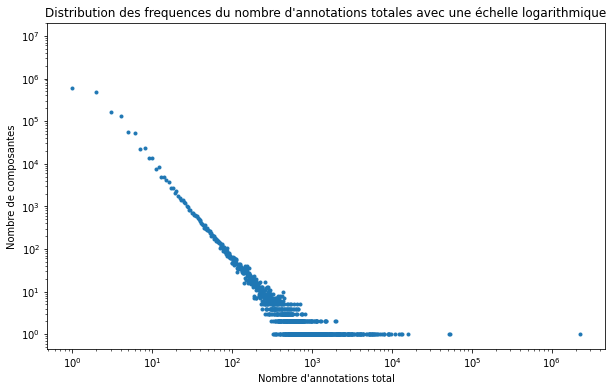

In [293]:
unique_sizes, counts = group_bn_annot_total.select("Nb_annotation_total").rdd.map(lambda x: x[0]).collect(),group_bn_annot_total.select("count").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes

plt.figure(figsize=(10,6))
plt.plot(unique_sizes, counts, marker='.', linestyle='none')
plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre d\'annotations total')
plt.ylabel('Nombre de composantes')
plt.title('Distribution des frequences du nombre d\'annotations totales avec une échelle logarithmique')

plt.show()

In [294]:
print("Size max  : ",np.max(unique_sizes), "avec frequece ",np.min(counts))
print("Frequence max des composantes de tailles petite : ",np.min(unique_sizes)," est de  : ",np.max(counts))

Size max  :  2231651 avec frequece  1
Frequence max des composantes de tailles petite :  0  est de  :  9095506


In [ ]:
group_per_component_2=graph.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))

group_per_component_3 = group_per_component.withColumn("Indice_homogénéités", calculate_size_udf(f.col("pfamAcc")) / calculate_size_udf(f.col("seq_id"))) \
    .withColumn("Nb_annotation_diff", calculate_size_udf(f.col("pfamAcc"))) \
    .withColumn("Nb_noeuds", calculate_size_udf(f.col("seq_id")))\
    .withColumn("Nb_annotation_total",  size("pfamAcc") )


group_bn_annot_total = group_per_component_3.groupBy(col("Nb_annotation_total")).count()

unique_sizes, counts = group_bn_annot_total.select("Nb_annotation_total").rdd.map(lambda x: x[0]).collect(),group_bn_annot_total.select("count").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes

plt.figure(figsize=(10,6))
plt.plot(unique_sizes, counts, marker='.', linestyle='none')
plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre d\'annotations total')
plt.ylabel('count')
plt.title('Distribution des frequences du nombre d\'annotations totales avec une échelle logarithmique')

plt.show()

In [32]:
print("helo")

helo
